# Part 1
Generate a word cloud based on the raw corpus -- I recommend you to use the [Python word_cloud library](https://github.com/amueller/word_cloud).
With the help of `nltk` (already available in your Anaconda environment), implement a standard text pre-processing 
pipeline (e.g., tokenization, stopword removal, stemming, etc.) and generate a new word cloud. Discuss briefly the pros and
cons (if any) of the two word clouds you generated.

In [1]:
import numpy as np
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
import matplotlib.pyplot as plt
import nltk as nl
from nltk.corpus import stopwords as nlstopw
import re
import string


%matplotlib inline
sns.set_context('notebook')
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500) # to see all columns
plt.rcParams['figure.figsize'] = (20, 15)

In [2]:
def plot_word_cloud(wordcloud):
    plt.imshow(wordcloud)
    plt.axis("off")

In [3]:
def plot_wordclouds(clouds, titles):
    r = len(clouds) // 2 + 1
    for i in range(0, len(clouds)):
        plt.subplot(r, 2, i+1)
        plt.title(titles[i])
        plt.imshow(clouds[i])
        plt.axis("off")

In [4]:
def make_wordcloud(s, stopwords):
    return WordCloud(stopwords=stopwords, width=600, height=400, prefer_horizontal=0.7, max_words=500, 
                          background_color='black').generate(s)

We take the _ExtractedBodyText_ and _ExtractedSubject_ fields and not the _RawText_ because the RawText contains a lot of words and fields that do not belong into the word cloud. 
_ExtractedBodyText_ and _ExtractedSubject_ have some NaNs, but there is still enough data to work with.

In [5]:
# read the raw emails:
emails = pd.read_csv('hillary-clinton-emails/Emails.csv', index_col='Id')
raw_text = ' '.join(emails.ExtractedBodyText.dropna().values) + ' '.join(emails.ExtractedSubject.dropna().values)
# len([subj for subj in emails.ExtractedBodyText.dropna() if 'State ' in subj])

On the raw corpus without stopword removal, _"the"_ is the most used word, followed by _"and"_, _"in"_, _"o"f_, _"to"_ etc. All stopwords that don't characterize the input text at all.

Every english text would probably generate the same result.
To show this, we took the raw text of the first book of the _hitchikers guide to the galaxy_ series. Notice how similar they are.

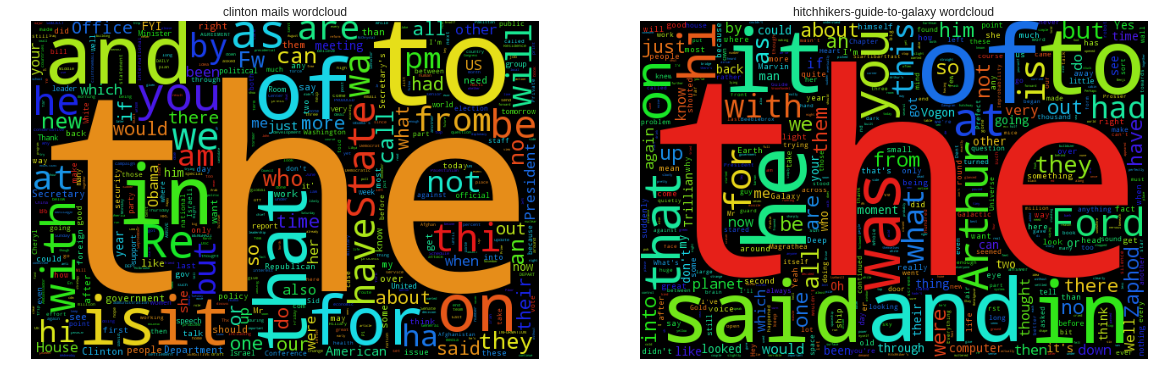

In [6]:
wc_emails = make_wordcloud(raw_text, stopwords=[''])

# source: http://paulyhart.blogspot.ch/2011/10/hitchhikers-guide-to-galaxy-text_28.html
hgttg_text = open('files/hitchikers_guide_to_the_galaxy.txt').read()
wc_hgttg = make_wordcloud(hgttg_text, stopwords=[''])

plot_wordclouds([wc_emails, wc_hgttg], ['clinton mails wordcloud', 'hitchhikers-guide-to-galaxy wordcloud'])

The WordCloud module has their own stopwords, lets see what happens when we use them.
For the emails, we also include words like _Re_, _Fw_, _Fvv_, _Fwd_ etc to the Stoplist since these words appear in the email subjects and don't really belong to the text.

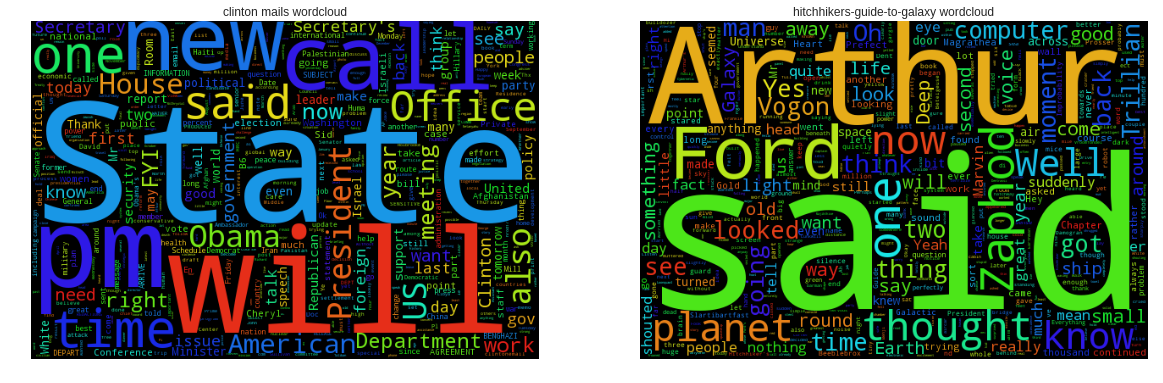

In [7]:
email_stopwords = set(['Re', 'RE', 'Fw', 'FW', 'Fvv', 'FVV', 'Fwd', 'FWD']).union(STOPWORDS)
wc_emails_stopw = make_wordcloud(raw_text, stopwords=email_stopwords)
wc_hgttg_stopw = make_wordcloud(hgttg_text, stopwords=STOPWORDS) 

plot_wordclouds([wc_emails_stopw, wc_hgttg_stopw], ['clinton mails wordcloud', 'hitchhikers-guide-to-galaxy wordcloud'])

The two word clouds already represent their text much better.

The clinton mails are clearly USA themed (with words like _"US"_, _"President"_, _"Obama"_, _"clinton"_ etc). It is interesting that _"will"_ is the most used word, followed by _"State"_. It seems that the emails speek often about the future. _"call"_, _"pm"_ and _"time"_ are other popular words, maybe implying that the emails are used to arrange phone-calls in the afternoon.

In the hitchhikers cloud, _"Ford"_, _"Zaphod"_, _"Trillian"_ and _"Arthur"_ are the protagonists of the book. _"said"_ is the most used word, which is no surprise for a book telling a story. Other words like _"planet"_, _"Vogon"_ and _"computer"_ are also quite characteristic for that book.

## Pipeline
Now lets create the pipeline abd use it on the emails:  
cleaning, tokenization, stopword removal, stemming

First we remove punktuation


In [8]:
# remove punktuation
raw_text = re.sub('['+string.punctuation+']', '', raw_text)

Then we tokenize, remove stepwords and use different stemmers to compare the output.

In [9]:
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.snowball import EnglishStemmer

# tokenize
nl.download('punkt') # needed for word tokenization
tokens = nl.word_tokenize(raw_text)
tokens = [tok.lower() for tok in tokens] # to lower case
print("after tokenizion:", len(tokens))

# remove stopwords
tokens = [tok for tok in tokens if tok not in email_stopwords]
print("after stopword removal:", len(tokens))

# stem the tokens
stemmer_L = LancasterStemmer()
stemmer_E = EnglishStemmer()
stemmed_L = [stemmer_L.stem(tok) for tok in tokens]
stemmed_E = [stemmer_E.stem(tok) for tok in tokens]



[nltk_data] Downloading package punkt to /home/lukas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
after tokenizion: 627006
after stopword removal: 377008


We compare 2 stemmers to the wordcloud generated without stemmed words.
The two stemmers are the Lancaster and Snowball (English) stemmer.

- tokens only is very similar to the raw_text without stepwords.
- Lancaster stems the words more agressive than the Snowball.
- Snowball seems good, is still very similar to the not stemmed one.
TODO 

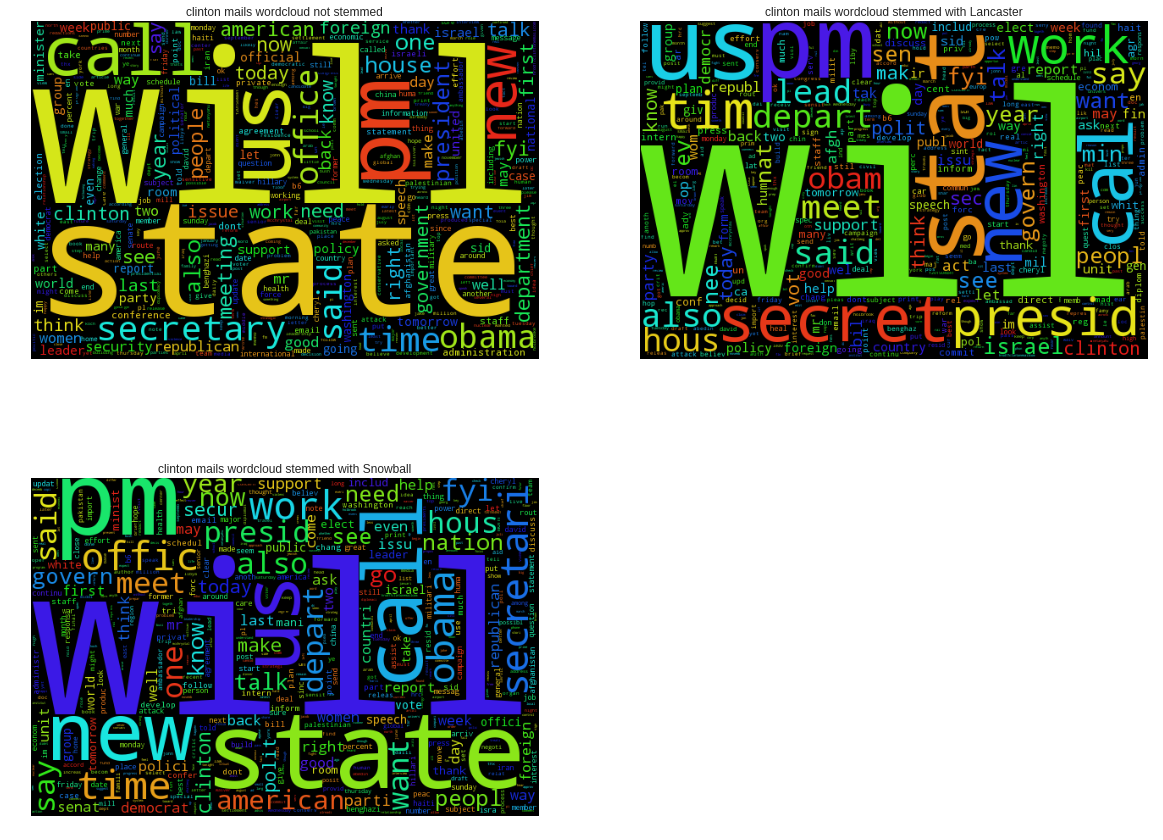

In [10]:
wc_tokens_emails = make_wordcloud(' '.join(tokens), stopwords=email_stopwords)
wc_stemmedL_emails = make_wordcloud(' '.join(stemmed_L), stopwords=email_stopwords)
wc_stemmedE_emails = make_wordcloud(' '.join(stemmed_E), stopwords=email_stopwords)

plot_wordclouds([wc_tokens_emails, wc_stemmedL_emails, wc_stemmedE_emails], 
                ['clinton mails wordcloud not stemmed', 'clinton mails wordcloud stemmed with Lancaster', 'clinton mails wordcloud stemmed with Snowball'])

A look at the top 10 words of the 3 wordclouds:

In [29]:
s1 = sorted(wc_tokens_emails.words_, key=lambda x: x[1], reverse=True)
s2 = sorted(wc_stemmedL_emails.words_, key=lambda x: x[1], reverse=True)
s3 = sorted(wc_stemmedE_emails.words_, key=lambda x: x[1], reverse=True)

print("tokens:           ", [t[0] for t in s1][:12])
print("stemmed Lancaster:", [t[0] for t in s2][:12])
print("stemmed Snowball :", [t[0] for t in s3][:12])

tokens:            ['will', 'state', 'pm', 'us', 'call', 'new', 'secretary', 'time', 'obama', 'said', 'office', 'president']
stemmed Lancaster: ['wil', 'stat', 'us', 'pm', 'cal', 'new', 'secret', 'presid', 'tim', 'work', 'depart', 'said']
stemmed Snowball : ['will', 'state', 'pm', 'call', 'us', 'new', 'secretari', 'time', 'offic', 'work', 'obama', 'presid']


They are quite similar. _"presid(ent)"_ appears higher in the Lancaster stemmed data but _"obama"_ is lower.

The following plot shows how few words appear the most, and that they are simiar for all 3 wordclouds

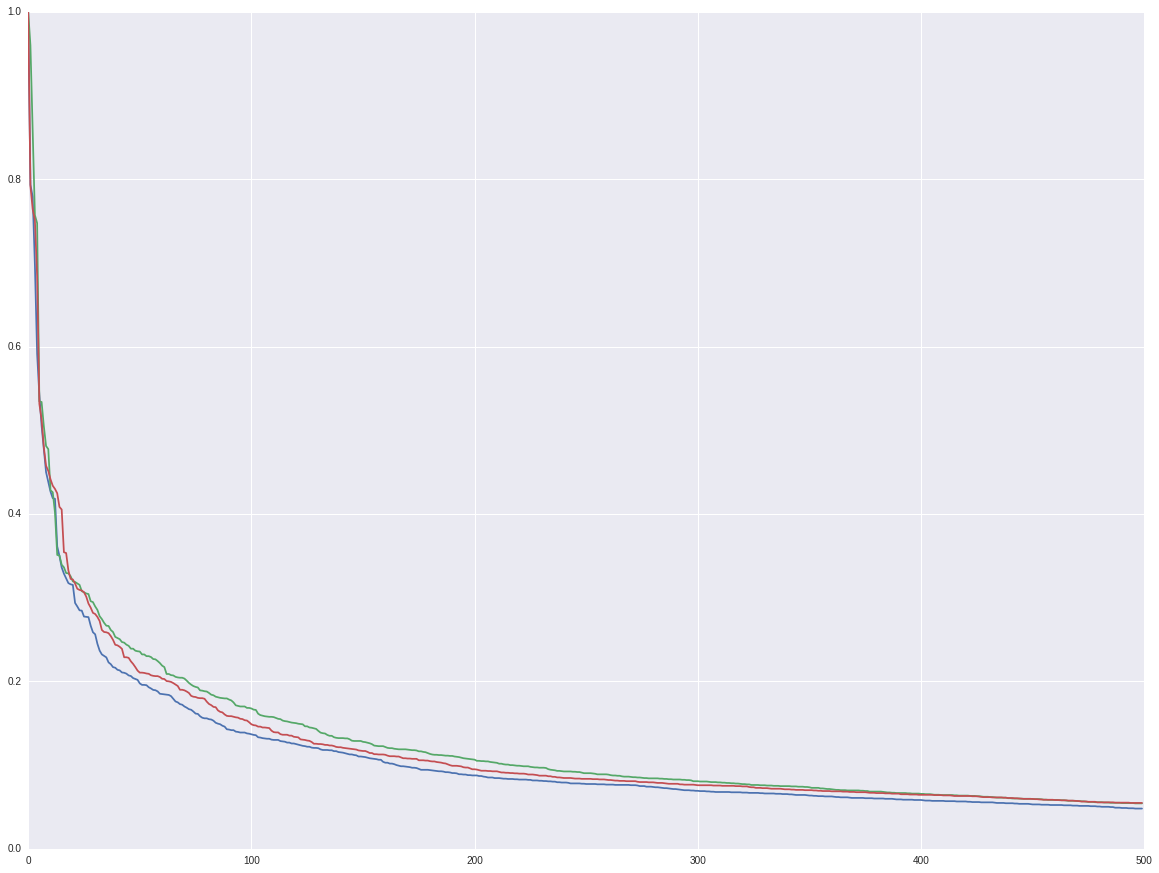

In [23]:
plt.plot([t[1] for t in s1])
plt.plot([t[1] for t in s2])
plt.plot([t[1] for t in s3])